In [1]:
import json
import spacy
import pandas as pd
import numpy as np
import hypernetx as hnx
from itertools import combinations
from collections import defaultdict, deque
import hypergraphx as hgx
import itertools

In [2]:
# Carica i dati
emotions = pd.read_csv("Emotions_Lemmatized.csv")
df = pd.read_csv("datafilteredbyemotion.csv")

# Data Preprocessing

Carichiamo i dati

In [ ]:
df_raw = pd.read_csv("SWOW-EN.complete.20180827.csv")[['cue', 'R1', 'R2', 'R3']]
df = df_raw
df.replace(["No more responses", "Unknown word"], np.nan, inplace=True)

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
# Convert to DataFrame for easier vectorized operations
obs_df = pd.DataFrame(df)

# Flatten the DataFrame to a Series for batch processing
flat_words = obs_df.stack().dropna()

# Batch lemmatize using SpaCy pipe
lemmatized = {}
for doc in nlp.pipe(flat_words.astype(str).unique(), batch_size=64):
    lemmatized[doc.text] = ' '.join(token.lemma_ for token in doc)

# Apply back the lemmatized words
obs_df = obs_df.map(lambda x: lemmatized.get(x) if isinstance(x, str) else x)

In [ ]:
obs_df = obs_df.replace(["", "NA", "None", "nan"], np.nan)
obs_df = obs_df.where(pd.notna(obs_df), np.nan)

# Write the DataFrame to a CSV file called "datalemmatized.csv"
obs_df.to_csv("datalemmatized.csv", index=False, na_rep="")

In [ ]:
df = pd.read_csv("datalemmatized.csv")

Lemmatize EmoLex

In [ ]:
# Load the emotions dataset
emotions = pd.read_csv(
    "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",
    sep="\t", 
    header=None, 
    names=["word", "emotion", "Active"]
)

# Filter to remove NaN rows
emotions = emotions.dropna()

In [ ]:
words_emotions = emotions["word"].unique()

for i in range(len(words_emotions)):
    # Obtain all rows with the same word
    rows = emotions[emotions["word"] == words_emotions[i]]
    
    doc = nlp(words_emotions[i])

    for token in doc:
        # Substituisci la parola con il lemma su tutte le righe rows
        emotions.loc[rows.index, "word"] = token.lemma_

In [ ]:
emotions = pd.read_csv("Emotions_Lemmatized_Unchecked.csv")

Add the neutral emotion

In [ ]:
# Find the last index of each group of 'word'
group_ends = emotions['word'].ne(emotions['word'].shift(-1))

# Get the last index of each group
last_indices = group_ends[group_ends].index

# Insert neutral rows at fractional indices
for i in last_indices:
    word = emotions.loc[i, 'word']
    emotions.loc[i + 0.5] = [word, 'neutral', 0]

# Sort by index to restore correct order, then reset
emotions = emotions.sort_index().reset_index(drop=True)

Activate the neutral emotion when the 8 emotionts are absent

In [ ]:
# Find words where all values of Ignore are 0
neutral_words = emotions.groupby("word")["Active"].sum()
neutral_words = neutral_words[neutral_words == 0].index.tolist()

# Update Active to 1 for "neutral" emotion for these words
emotions.loc[(emotions["word"].isin(neutral_words)) & (emotions["emotion"] == "neutral"), "Active"] = 1

Eliminate the redundancy from lemmatization

In [ ]:
# Group by word and emotion
emotions = emotions.groupby(["word", "emotion"]).sum().reset_index()

# If Active is bigger than 1, set it to 1
emotions["Active"] = emotions["Active"].clip(upper=1)

In [ ]:
# Filter the emotions DataFrame to keep only the emotions in emotions_list
emotion_list = ["trust", "fear", "anger", "anticipation", "joy", "sadness", "surprise", "disgust", "neutral"]

emotions = emotions[emotions["emotion"].isin(emotion_list)]

# Keep only the words that have at least one emotion. That is the sum of Active is at least 1
#emotions = emotions[emotions.groupby("word")["Active"].transform("sum") > 0]

In [ ]:
# Save the cleaned emotions DataFrame to a CSV file
emotions.to_csv("Emotions_Lemmatized.csv", index=False)

In [ ]:
emotions = pd.read_csv("Emotions_Lemmatized.csv")

Intersechiamo SWOW ed EmoLex

In [ ]:
# Prendi tutte le parole uniche nella colonna "word"
unique_words = set(emotions["word"].unique())

df = df.map(lambda token: str(token) if str(token) in unique_words else None)

In [ ]:
df.to_csv("datafilteredbyemotion.csv", index=False)

In [ ]:
df = pd.read_csv("datafilteredbyemotion.csv")

In [3]:
# Filter to keep only rows where Ignore == 1
emotions_plutchik = emotions[(emotions["Active"] == 1)]

# Create a dictionary {word -> set of associated emotions} to avoid duplicates
emotion_dict = defaultdict(set)
for row in emotions_plutchik.itertuples(index=False):
    emotion_dict[row.word].add(row.emotion)  # Using a set prevents duplicates

for word in emotion_dict:
    emotion_dict[word] = set(emotion_dict[word])

# Ipergrafo fondante

In [4]:
def normalize(cell):
    # Eliminate NaN-like values before string conversion
    if pd.isna(cell):
        return None
    val = str(cell).strip().lower()
    return val if val not in ("", "none", "nan") else None

# Step 1: Normalize and clean
cleaned_rows = [
    [normalize(cell) for cell in row if normalize(cell) is not None]
    for row in df.values.tolist()
]

# Step 2: Drop empty edges
cleaned_rows = [row for row in cleaned_rows if row]

ipergrafo = hnx.Hypergraph(cleaned_rows)


In [5]:
ipergrafo = ipergrafo.collapse_edges(return_counts=False)


/Users/lucadicola/Tesi Python/venv/lib/python3.11/site-packages/hypernetx/classes/hyp_view.py:136: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return pd.concat([df, non_user_defined_properties]).loc[list(self.items)]


In [6]:
nodes_largest = next(ipergrafo.s_connected_components(edges = False))
ipergrafo = ipergrafo.restrict_to_nodes(nodes_largest)

In [ ]:
#Calculate stats
import matplotlib.pyplot as plt
from hypernetx.algorithms.s_centrality_measures import s_betweenness_centrality, s_closeness_centrality
# Number of edges
#print("Number of hyperedges:", ipergrafo.shape[1])

# Compute node degrees
node_degree = {node: ipergrafo.degree(node, s=1) for node in ipergrafo.nodes}

# Compute degree distribution
degree_counts = defaultdict(int)
for degree in node_degree.values():
    degree_counts[degree] += 1

degree_df = pd.DataFrame(list(degree_counts.items()), columns=["Degree", "Count"])
degree_df.sort_values(by="Degree", inplace=True)

# Save degree distribution to CSV
degree_df.to_csv(f"Fundational/degree_distribution.csv", index=False)

# Sort nodes by degree
degree_list = sorted(node_degree.items(), key=lambda x: x[1], reverse=True)

# Create DataFrame for top 20 nodes by degree
degree_top_df = pd.DataFrame(degree_list, columns=["Node", "Degree"])
#degree_top_df.to_csv(f"Multiplex/nodes_degree_multiplex.csv", index=False)

# Log-log histogram
plt.figure(figsize=(8, 6))
plt.scatter(np.log10(degree_df["Degree"]), np.log10(degree_df["Count"]), c="b", label="Node Degree")
plt.xlabel("Log Degree")
plt.ylabel("Log Count")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

"""
# Compute s-betweenness centrality for nodes
betweenness_centrality = s_betweenness_centrality(ipergrafo, s=2, edges=False, return_singletons = False)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=["Node", "s_betweenness"])
betweenness_df.sort_values(by="s_betweenness", ascending=False, inplace=True)
betweenness_df.to_csv(f"Multiplex/nodes_betweenness_multiplex.csv", index=False)

# Compute s-closeness centrality
closeness_centrality = s_closeness_centrality(ipergrafo, s=2, edges=False, return_singletons = False)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=["Node", "s_closeness"])
closeness_df.sort_values(by="s_closeness", ascending=False, inplace=True)
closeness_df.to_csv(f"Multiplex/nodes_closeness_ipergrafo.csv", index=False)

 """

""" # Compute s-betweenness centrality for edges
betweenness_centrality_edges = s_betweenness_centrality(hyp, s=2, edges=True)
betweenness_data = [(set(hyp.edges[edge]), score) for edge, score in betweenness_centrality_edges.items()]
betweenness_df_edges = pd.DataFrame(betweenness_data, columns=["Edge (Nodes)", "s_betweenness"])
betweenness_df_edges.sort_values(by="s_betweenness", ascending=False, inplace=True)
betweenness_df_edges.head(20).to_csv(f"top_edges_betweenness_{emotion}.csv", index=False)
print(betweenness_df_edges.head(20)) """

# Layers

In [7]:
emotion_list = ["trust", "fear", "anger", "anticipation", "joy", "sadness", "surprise", "disgust", "neutral"]

# Dictionary to store emotion-specific hyperedges
emotion_hyperedges = {}

for emotion in emotion_list:
    hyperedges = []
    for edge in ipergrafo.incidence_dict:
        nodes = ipergrafo.incidence_dict[edge]
        # Keep the nodes that are in the current emotion
        filtered_nodes = [node for node in nodes if emotion in emotion_dict[node]]
        if filtered_nodes:
            hyperedges.append(filtered_nodes)
    # Store the result
    emotion_hyperedges[emotion] = hyperedges

In [8]:
emotion_hypergraphs = {
    emotion: hnx.Hypergraph(hyperedges).collapse_edges(return_counts=False)
    for emotion, hyperedges in emotion_hyperedges.items()
}

/Users/lucadicola/Tesi Python/venv/lib/python3.11/site-packages/hypernetx/classes/hyp_view.py:136: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return pd.concat([df, non_user_defined_properties]).loc[list(self.items)]
/Users/lucadicola/Tesi Python/venv/lib/python3.11/site-packages/hypernetx/classes/hyp_view.py:136: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return pd.concat([df, non_user_defined_properties]).loc[list(self.items)]
/Users/lucadicola/Tesi Python/venv/lib/python3.11/site-packages/hypernetx/classes/hyp_view.py:136: FutureWarning: The beha

In [9]:
hypergraph_sum = hnx.Hypergraph()

for emotion in emotion_list:
    hypergraph_sum = hypergraph_sum.union(emotion_hypergraphs[emotion])

nodes_collapsed = next(hypergraph_sum.s_connected_components(edges=False))

/Users/lucadicola/Tesi Python/venv/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:2732: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat([df1, df2])


In [10]:
for emotion in emotion_list:
    emotion_hypergraphs[emotion] = emotion_hypergraphs[emotion].restrict_to_nodes(nodes_collapsed)

In [11]:
for emotion in emotion_list:
    temp_nodes = next(emotion_hypergraphs[emotion].s_connected_components(edges=False, s = 2))
    emotion_hypergraphs[emotion] = emotion_hypergraphs[emotion].restrict_to_nodes(temp_nodes)

In [12]:
hypergraph_sum = hnx.Hypergraph()

for emotion in emotion_list:
    hypergraph_sum = hypergraph_sum.union(emotion_hypergraphs[emotion])

nodes_collapsed = next(hypergraph_sum.s_connected_components(edges=False))

/Users/lucadicola/Tesi Python/venv/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:2732: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat([df1, df2])


# Create the multiplex

In [14]:
hypergraph_sum = hnx.Hypergraph()

for emotion in emotion_list:
    hypergraph_sum = hypergraph_sum.union(emotion_hypergraphs[emotion])

nodes_multiplex = hypergraph_sum.nodes
multiplex = ipergrafo.restrict_to_nodes(nodes_multiplex)

/Users/lucadicola/Tesi Python/venv/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:2732: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat([df1, df2])


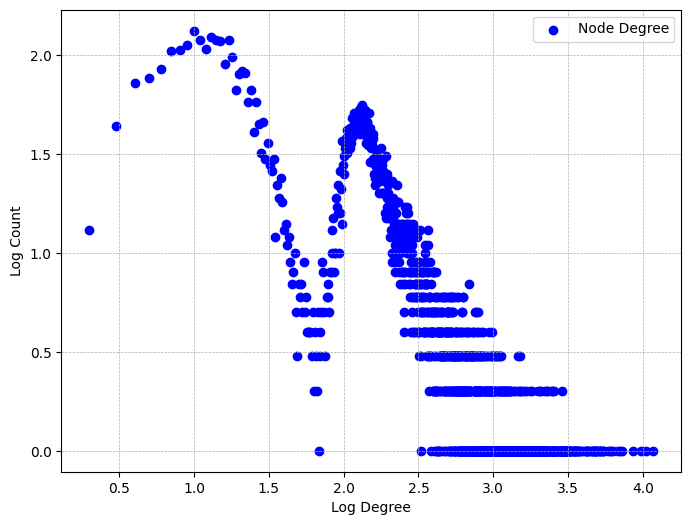

In [17]:
#Calculate stats
import matplotlib.pyplot as plt
from hypernetx.algorithms.s_centrality_measures import s_betweenness_centrality, s_closeness_centrality
# Number of edges
#print("Number of hyperedges:", ipergrafo.shape[1])
"""

# Compute s-closeness centrality
closeness_centrality = s_closeness_centrality(multiplex, s=2, edges=False, return_singletons = False)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=["Node", "s_closeness"])
closeness_df.sort_values(by="s_closeness", ascending=False, inplace=True)
closeness_df.to_csv(f"Multiplex/nodes_closeness_multiplex.csv", index=False)

# Compute s-betweenness centrality for nodes
betweenness_centrality = s_betweenness_centrality(multiplex, s=2, edges=False, return_singletons = False)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=["Node", "s_betweenness"])
betweenness_df.sort_values(by="s_betweenness", ascending=False, inplace=True)
betweenness_df.to_csv(f"Multiplex/nodes_betweenness_multiplex.csv", index=False)

"""

# Compute node degrees
node_degree = {node: multiplex.degree(node, s=1) for node in multiplex.nodes}

# Compute degree distribution
degree_counts = defaultdict(int)
for degree in node_degree.values():
    degree_counts[degree] += 1

degree_df = pd.DataFrame(list(degree_counts.items()), columns=["Degree", "Count"])
degree_df.sort_values(by="Degree", inplace=True)

# Save degree distribution to CSV
degree_df.to_csv(f"Multiplex/degree_distribution_multiplex.csv", index=False)

# Sort nodes by degree
degree_list = sorted(node_degree.items(), key=lambda x: x[1], reverse=True)

# Create DataFrame for top 20 nodes by degree
degree_top_df = pd.DataFrame(degree_list, columns=["Node", "Degree"])
#degree_top_df.to_csv(f"Multiplex/nodes_degree_multiplex.csv", index=False)

 # Log-log histogram
plt.figure(figsize=(8, 6))
plt.scatter(np.log10(degree_df["Degree"]), np.log10(degree_df["Count"]), c="b", label="Node Degree")
plt.xlabel("Log Degree")
plt.ylabel("Log Count")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show() 

# Interlayers

In [ ]:
emotion_list = ["trust", "fear", "anger", "anticipation", "joy", "sadness", "surprise", "disgust", "neutral"]

# Assumiamo: emotion_list contiene 9 emozioni
combinations = list(itertools.combinations(emotion_list, 2))

results = {}

for emotion_from, emotion_to in combinations:
    my_list = []

    for hyperedge in multiplex.edges():
        nodes = multiplex.incidence_dict[hyperedge]

        # Filtra i nodi per emozione
        from_nodes = [node for node in nodes if emotion_from in emotion_dict.get(node, set())]
        to_nodes   = [node for node in nodes if emotion_to in emotion_dict.get(node, set())]

        for node_from in from_nodes:
            for node_to in to_nodes:
                    my_list.append({
                        "word1": node_from,
                        "word2": node_to
                    })

    # Ensure unique pairs
    my_list = [dict(t) for t in {tuple(d.items()) for d in my_list}]

    filename = f"{emotion_from}_{emotion_to}.json"
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(my_list, f, indent=4)
    print(f"Saved: {filename} ({len(my_list)} pairs)")

## Check the results

In [ ]:
emotion_list = ["trust", "fear", "anger", "anticipation", "joy", "sadness", "surprise", "disgust", "neutral"]

combinations = list(itertools.combinations(emotion_list, 2))

In [ ]:
results = {}

# Process each file
for emotion_from, emotion_to in combinations:
    filename = f"{emotion_from}_{emotion_to}.json"
    
    # Load data from file
    with open(filename, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    results[(emotion_from, emotion_to)] = data
    
    # Collect all unique words
    all_words = {pair["word1"] for pair in data} | {pair["word2"] for pair in data}
    word_list = sorted(all_words)

    # Initialize counters
    unrelated_count = 0
    emotion_from_count = 0
    emotion_to_count = 0

    for word in word_list:
        emotions = emotion_dict.get(word, set())

        if f"{emotion_from}" in emotions:
            emotion_from_count += 1
        if f"{emotion_to}" in emotions:
            emotion_to_count += 1

        if emotions.isdisjoint({emotion_from, emotion_to}):
            print(f"{word} is associated with emotions: {emotions}")
            count += 1

    print(f"{filename}: {emotion_from}={emotion_from_count}, {emotion_to}={emotion_to_count}, unrelated={unrelated_count}")

# Statistiche Layers

In [ ]:
for emotion in emotion_list:
    nodes_largest_component = next(emotion_hypergraphs[emotion].s_connected_components(edges=False))
    emotion_hypergraphs[emotion] = emotion_hypergraphs[emotion].restrict_to_nodes(nodes_largest_component)

In [ ]:
import matplotlib.pyplot as plt
from hypernetx.algorithms.s_centrality_measures import s_betweenness_centrality, s_closeness_centrality

for emotion, hyp in emotion_hypergraphs.items():
    print(f"Analysis for emotion: {emotion}")

    print(hyp.is_connected())

    # Number of edges
    print("Number of hyperedges:", hyp.shape[1])
    print("Number of nodes:", hyp.shape[0])

    # Number of nodes in edges of size > 1
    num_nodes_non_trivial = hyp.shape[0] - len(hyp.singletons())
    print("Number of nodes in non-trivial hyperedges:", num_nodes_non_trivial)

    # Compute node degrees
    node_degree = {node: hyp.degree(node) for node in hyp.nodes}

    # Sort nodes by degree
    degree_list = sorted(node_degree.items(), key=lambda x: x[1], reverse=True) 

    # Create DataFrame for nodes by degree
    degree_df = pd.DataFrame(degree_list, columns=["Node", "Degree"])
    degree_df.to_csv(f"Degree filtered/nodes_degree_{emotion}.csv", index=False)
    
    # Compute s-betweenness centrality for nodes
    betweenness_centrality = s_betweenness_centrality(hyp, s=2, edges=False, return_singletons = False)
    betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=["Node", "s_betweenness"])
    betweenness_df.sort_values(by="s_betweenness", ascending=False, inplace=True)
    betweenness_df.to_csv(f"Betweenness filtered/top_nodes_betweenness_{emotion}.csv", index=False)

    # Compute s-closeness centrality
    closeness_centrality = s_closeness_centrality(hyp, s=2, edges=False, return_singletons = False)
    closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=["Node", "s_closeness"])
    closeness_df.sort_values(by="s_closeness", ascending=False, inplace=True)
    closeness_df.to_csv(f"Closeness filtered/top_nodes_closeness_{emotion}.csv", index=False)

        
    # Compute degree distribution
    degree_counts = defaultdict(int)
    for degree in node_degree.values():
        degree_counts[degree] += 1

    degree_df = pd.DataFrame(list(degree_counts.items()), columns=["Degree", "Count"])
    degree_df.sort_values(by="Degree", inplace=True)

    # Save degree distribution to CSV
    degree_df.to_csv(f"Degree distribution filtered/degree_distribution_{emotion}.csv", index=False)

     # Log-log histogram
    plt.figure(figsize=(8, 6))
    plt.scatter(np.log10(degree_df["Degree"]), np.log10(degree_df["Count"]), c="b", label="Node Degree")
    plt.xlabel("Log Degree")
    plt.ylabel("Log Count")
    plt.title(f"Log-Log Degree Distribution of Nodes for {emotion}")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()


# Word Cloud

{'abacus': 2, 'abundance': 4, 'academic': 2, 'accolade': 1, 'account': 20, 'accountant': 14, 'accurate': 1, 'achieve': 1, 'achievement': 6, 'admiration': 1, 'advice': 3, 'advise': 2, 'advocate': 3, 'affection': 1, 'agree': 4, 'agreement': 3, 'alive': 1, 'allegiance': 1, 'ambition': 4, 'analyst': 1, 'angel': 2, 'appreciation': 2, 'apprentice': 1, 'approve': 3, 'armor': 1, 'aspiration': 2, 'assert': 1, 'assessment': 2, 'associate': 1, 'association': 1, 'assurance': 6, 'assure': 2, 'attorney': 6, 'aunt': 2, 'authentic': 1, 'authority': 4, 'authorization': 1, 'award': 7, 'babysitter': 1, 'backer': 1, 'badge': 1, 'bank': 79, 'banker': 18, 'bargain': 6, 'barter': 9, 'believe': 1, 'benefactor': 2, 'betroth': 1, 'birth': 3, 'blanket': 3, 'bless': 1, 'blessing': 2, 'bounty': 10, 'bride': 1, 'brother': 1, 'buddy': 1, 'budget': 16, 'bureaucracy': 1, 'bursary': 2, 'butler': 1, 'calculator': 2, 'call': 1, 'cap': 1, 'cash': 41, 'cashier': 15, 'cautious': 1, 'celebration': 1, 'celebrity': 5, 'center'

/Users/lucadicola/Tesi Python/venv/lib/python3.11/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


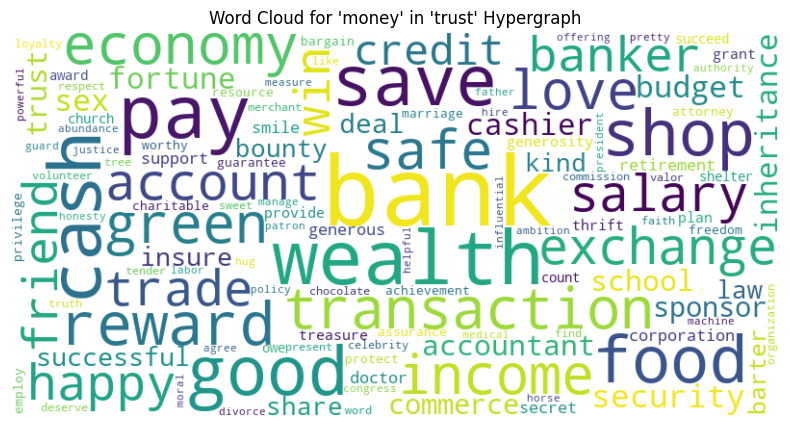

/Users/lucadicola/Tesi Python/venv/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:912: UserWarning: money is not in hypergraph None.
  warnings.warn(f"{node} is not in hypergraph {self.name}.")


{'abuse': 4, 'accuse': 1, 'aggravation': 1, 'agony': 1, 'alcoholism': 1, 'anger': 9, 'angry': 5, 'anguish': 1, 'annoyance': 1, 'annoying': 6, 'anxiety': 3, 'argue': 1, 'argument': 1, 'arm': 3, 'arrogant': 1, 'assassin': 1, 'asshole': 3, 'attack': 1, 'attorney': 5, 'avarice': 2, 'awful': 2, 'bad': 14, 'bang': 2, 'barrier': 1, 'battery': 1, 'battle': 1, 'bear': 2, 'beat': 2, 'bee': 3, 'belt': 1, 'betray': 1, 'bitch': 4, 'blackmail': 14, 'bloody': 1, 'bomb': 1, 'box': 4, 'break': 10, 'bully': 1, 'bust': 1, 'butcher': 1, 'campaign': 3, 'cancer': 1, 'cash': 25, 'caution': 1, 'celebrity': 3, 'challenge': 1, 'cheat': 8, 'coerce': 3, 'coercion': 2, 'communism': 2, 'confinement': 1, 'conflict': 1, 'confusion': 1, 'constraint': 2, 'corrupt': 9, 'court': 11, 'crack': 2, 'craze': 1, 'crazy': 2, 'crime': 27, 'criminal': 6, 'cross': 1, 'cut': 3, 'damage': 3, 'death': 9, 'deceit': 5, 'deceive': 2, 'deflate': 1, 'delinquent': 2, 'demand': 5, 'deprivation': 1, 'desert': 2, 'deserve': 2, 'despair': 1, '

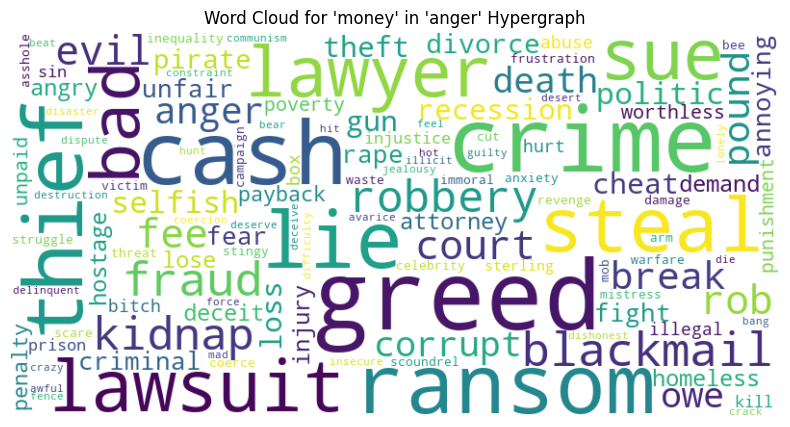

{'abundance': 2, 'accolade': 1, 'achievement': 8, 'acquire': 7, 'advance': 5, 'adventure': 1, 'airport': 1, 'alive': 1, 'ambition': 6, 'angel': 1, 'anticipation': 1, 'anxiety': 1, 'anxious': 2, 'appeal': 2, 'approach': 1, 'art': 4, 'aspiration': 2, 'auction': 4, 'audience': 1, 'award': 10, 'banquet': 1, 'basketball': 1, 'betroth': 1, 'beware': 1, 'birth': 1, 'birthday': 3, 'bless': 1, 'blessing': 2, 'board': 2, 'bonus': 11, 'bountiful': 1, 'bounty': 13, 'bride': 1, 'buddy': 1, 'buzz': 1, 'call': 1, 'cap': 1, 'career': 13, 'cash': 31, 'caution': 1, 'cautious': 1, 'celebration': 1, 'celebrity': 4, 'champion': 2, 'charitable': 7, 'chastity': 1, 'cheer': 2, 'cherish': 1, 'child': 5, 'chocolate': 3, 'church': 5, 'climax': 1, 'clock': 2, 'closure': 1, 'clue': 1, 'comfort': 3, 'compensate': 2, 'competition': 1, 'complete': 3, 'completion': 2, 'continue': 1, 'convince': 1, 'court': 2, 'crap': 1, 'crave': 1, 'cream': 2, 'crown': 1, 'curiosity': 2, 'daily': 1, 'deal': 5, 'death': 9, 'delightful'

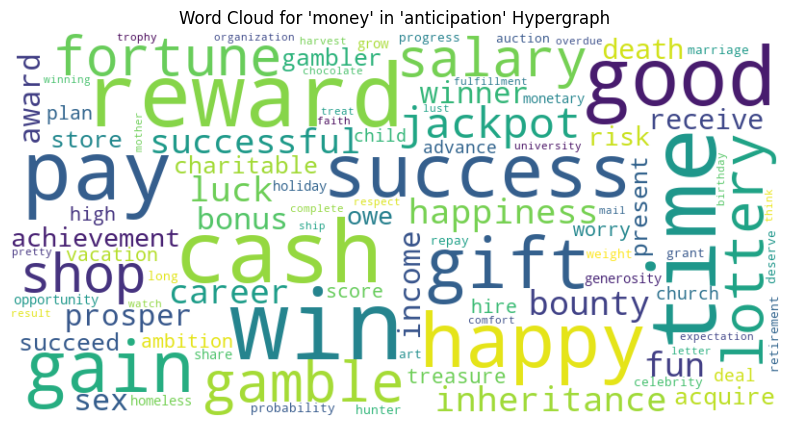

{'abundance': 5, 'abundant': 3, 'accolade': 1, 'accomplish': 3, 'achieve': 1, 'achievement': 8, 'admiration': 1, 'adorable': 1, 'advance': 5, 'affection': 1, 'affluence': 2, 'alive': 1, 'ambition': 6, 'amusement': 2, 'angel': 1, 'appreciation': 1, 'approve': 2, 'art': 4, 'aspiration': 2, 'authentic': 1, 'award': 9, 'baby': 2, 'banquet': 1, 'basketball': 1, 'beach': 1, 'beautiful': 1, 'beauty': 3, 'beer': 2, 'betroth': 1, 'birth': 3, 'birthday': 3, 'bless': 1, 'blessing': 2, 'bliss': 1, 'bonus': 15, 'bountiful': 2, 'bounty': 9, 'bride': 1, 'buddy': 1, 'cash': 31, 'celebration': 1, 'celebrity': 4, 'champion': 2, 'charitable': 8, 'charity': 18, 'charm': 1, 'cheer': 2, 'cherish': 2, 'child': 10, 'childhood': 1, 'chocolate': 5, 'church': 6, 'clean': 2, 'climax': 1, 'closeness': 1, 'closure': 1, 'comfort': 4, 'communion': 1, 'compensate': 2, 'complete': 4, 'completion': 2, 'confidence': 1, 'confident': 1, 'content': 1, 'cream': 2, 'create': 1, 'crown': 2, 'dance': 1, 'deal': 4, 'delicious': 

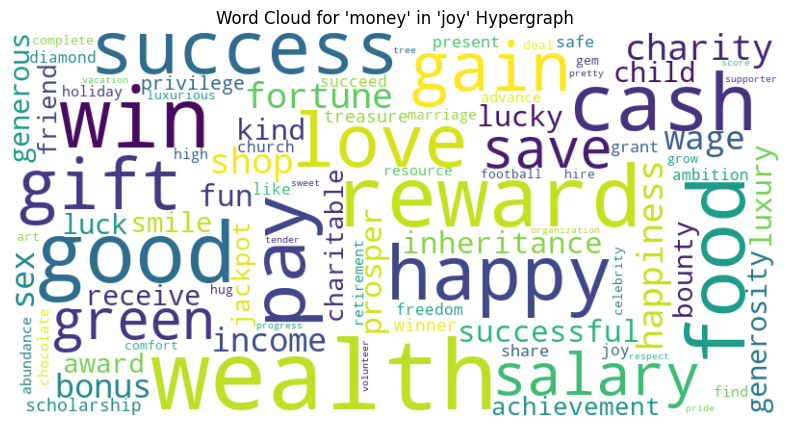

{'abduction': 2, 'accident': 1, 'accolade': 1, 'advance': 2, 'alarm': 1, 'angel': 1, 'art': 1, 'aspiration': 2, 'attack': 1, 'award': 5, 'bang': 3, 'betray': 1, 'birthday': 3, 'blessing': 2, 'bomb': 1, 'bonus': 7, 'break': 3, 'buck': 2, 'cable': 1, 'catch': 1, 'celebration': 1, 'celebrity': 2, 'chance': 9, 'cheer': 1, 'cherish': 1, 'climax': 1, 'crash': 3, 'cream': 1, 'crown': 1, 'curiosity': 1, 'deal': 4, 'death': 5, 'deceit': 2, 'disaster': 3, 'divorce': 2, 'eager': 1, 'earthquake': 1, 'electric': 1, 'emergency': 1, 'entertainment': 1, 'excel': 1, 'excite': 1, 'excitement': 1, 'exciting': 1, 'expect': 1, 'experiment': 1, 'explosive': 1, 'feel': 1, 'finally': 1, 'flirt': 1, 'fortune': 9, 'gamble': 13, 'gambler': 6, 'gasp': 1, 'generosity': 4, 'gift': 13, 'good': 13, 'goodness': 1, 'graduation': 1, 'guess': 2, 'hero': 1, 'high': 3, 'honeymoon': 1, 'hope': 1, 'hopeful': 1, 'horror': 1, 'independence': 1, 'inheritance': 10, 'inspire': 1, 'intrigue': 1, 'jackpot': 11, 'jerk': 1, 'jubilee'

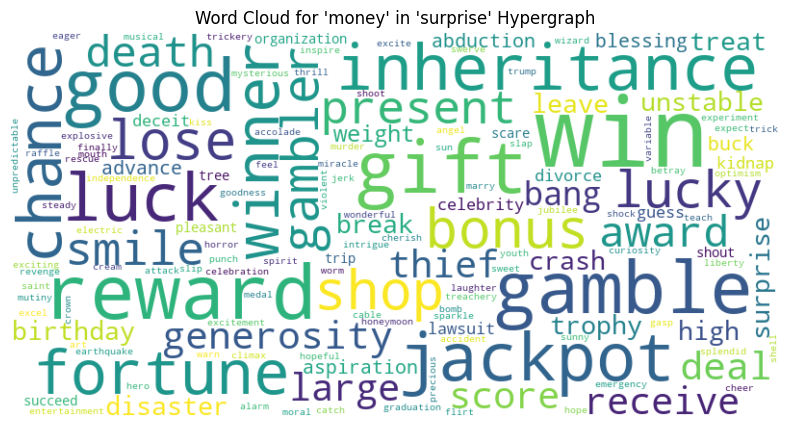

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word = "money"

for emotion, hyp in emotion_hypergraphs.items():
    all_neigh = hyp.neighbors(word, s=1)
    if not all_neigh:
        continue

    freq_dict = {n: 1 for n in all_neigh}  # initialize with s=1

    # Try larger values of s and overwrite previous values if node is still present
    max_possible_s = len(hyp.nodes.memberships[word])  # max number of edges `word` can share
    for s in range(2, max_possible_s + 1):
        current = hyp.neighbors(word, s=s)
        for n in current:
            freq_dict[n] = s  # overwrite with higher value

    print(freq_dict)

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_font_size=100,
        min_font_size=10
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for '{word}' in '{emotion}' Hypergraph")
    plt.show()

# Emotion flower

In [ ]:
import nltk
import emoatlas
from emoatlas import EmoScores

In [ ]:
emos = EmoScores()

# Load the file
with open("interlayers/fear_joy.json", "r", encoding="utf-8") as f:
    interlayer_data = json.load(f)

# Extract all words from both word1 and word2, and get the unique set
all_words = set()

for pair in interlayer_data:
    all_words.add(pair["word1"])
    all_words.add(pair["word2"])

word_list = sorted(all_words)
print(len(word_list))

word_string = " ".join(all_words)

# Apply the draw_formamentis_flower method
emos.draw_formamentis_flower(word_string)